# **Market Basket Analysis Project**

# **What is Market Basket Analysis?**

Market Basket Analysis (MBA) is a data analysis tool used to discover items that are frequently purchased together. You encounter this on websites like Amazon when you see a list of 'Frequently Bought Together' items on the page of the item you are considering to buy. In a restaurant this may be manifested through item pairings on a menu.

Since the data used in this project is from a restaurant, we will talk about MBA's application in the restaurant business. Thomas Joseph has a very thorough article which can be found [here](https://blog.aspiresys.com/digital/big-data-analytics/menu-engineering-market-basket-analysis/), which I will summarize parts of. Among other things, MBA can help a restaurant determine 1) which items are most likely to be ordered on certain days/times/seasons, 2) which items are most likely to be bought together, and 3) relationships between item sales and special promotions.

MBA is based on association rules, of which there are three main types: support, confidence, and lift. We can think of an association rule, typically written as {Item A} -> {Item B}, or simply, If Item A is bought, then so is B.

So, for the association rule A -> B, the three rules can be generated as:

*Support = P(A & B)*

*Confidence = Support / P(B)*

*Lift = Confidence/ P(A)*


As an example, we will pretend that our food enterprise, 'Phil's Taco Stand'. In reality, we would like hundreds of thousands of transaction records to produce a more reliable result, but we will stick with a small dataset of 100 transactions for ease of explanation.

**Phil's Taco Stand**
- 100 customers transactions
- 20 purchased pork tacos, 15 bought lime margaritas, 10 bought both. 
- Support(pork taco and lime margarita) = 10/100 = 0.1
- Confidence = support / P(lime margarita) = 0.1 / 0.15 = 0.66
- Lift = confidence / P(pork taco) = 0.66 / 0.2 = 3.3

So, our lift for the rule {pork tacos} -> {lime margaritas} is 3.3

How do we interpret this number though?

Essentially, a lift value of 1 indicates that the rules are totally independent. On the other hand, a lift value greater than 1 is indicative of a meaningful pattern. Therefore, we could say that our rule of *customers who buy pork tacos, are likely to buy lime margaritas* will be useful to our taco stand business.


# **What Value Can it Bring to a Restaurant Business?**


One thing I am trying to emphasize in each project is that analyses like this (or customer segmentation with kmeans clustering in my last project) are not an end product, but rather they are a step in a process, a single stroke in an entire painting, or a piece to a puzzle. It is the same with association rules and MBA. They should be a part of a larger strategy by a business to harness the power of the data to make decisions that make a positive impact.

So, now that we know (and have the data to back it up) that pork tacos and lime margaritas are commonly bought together, what do we do next? How can we use this information to alter or improve some aspect of the business that will produce a positive outcome? 

Here are a few practical things we can do with this information:

1. Use this rule (and others we could extract from MBA) to adjust our menu to include item pairing recommendations. Nudge customers not sure if they want to drink or not by letting them know that 'lime margaritas go well with pork tacos'.

2. Use it for upselling, having servers recommend a lime margarita to customers who want pork tacos

3. Begin offering a taco / margarita combo (perhaps with another item by another association rule generated from the analysis)

These are just a few examples. Now, lets get to coding. Unfortunately, no dataset on 'Phil's Taco Stand' exist (some say the restuarant itself is just a mythical legend), so we will be using an open source dataset from a bakery / cafe available on [kaggle.com](https://www.kaggle.com/mittalvasu95/the-bread-basket).

Now, let's proceed to the data and coding portion.

# **Load Libraries and Dataset** 

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

In [4]:
file = "C:\\Users\\Phillip's PC\\Desktop\\MBA Project\\bread basket.csv"

breadbasket = pd.read_csv(file)

breadbasket.head(10)

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend
5,3,Cookies,30-10-2016 10:07,morning,weekend
6,4,Muffin,30-10-2016 10:08,morning,weekend
7,5,Coffee,30-10-2016 10:13,morning,weekend
8,5,Pastry,30-10-2016 10:13,morning,weekend
9,5,Bread,30-10-2016 10:13,morning,weekend


# **Data Exploration and Visualization**

We will do only a little data exploration and visualization since most of our data is categorical. Three questions we will try to answer are:

1. What are the 'top 10' best selling items?

2. What are the best selling items in the morning? afternoon? evening? night?

3. What are the best selling items during weekdays? weekends?

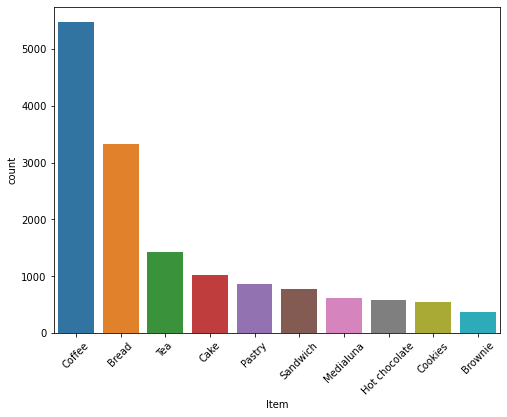

In [5]:
plt.figure(figsize = (8, 6))
sns.countplot(data = breadbasket, x = 'Item', order = breadbasket['Item'].value_counts().iloc[:10].index)
plt.xticks(rotation = 45)
plt.show()

Coffee is the best selling item by far. Which is not surprising since this is a bakery. It may be more informative to see which items sell best during different parts of the day and on weekdays vs. weekends. We will see that below.

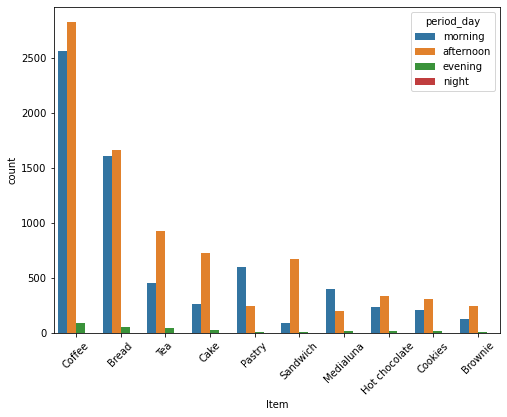

In [6]:
plt.figure(figsize = (8, 6))
sns.countplot(data = breadbasket, x = 'Item', hue = 'period_day', order = breadbasket['Item'].value_counts().iloc[:10].index)
plt.xticks(rotation = 45)
plt.show()

The trends for mornings and evening are pretty similar. Confirming what we probably knew from intuition, pastries are more popular in the morning, and sandwiches are more popular in the afternoon. Evenings are relatively dead (maybe because our shop closes early, or people are not typically drinking coffee later in the day). Nights are non-existent, likely because the shop is closed.

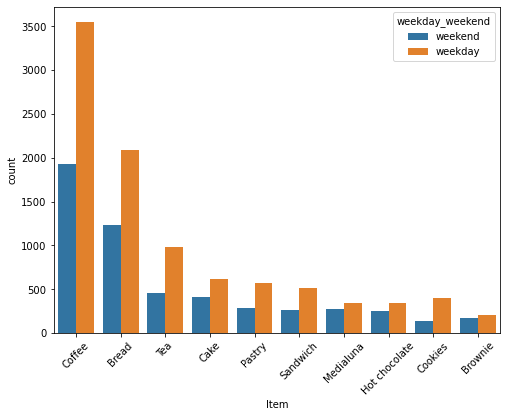

In [7]:
plt.figure(figsize = (8, 6))
sns.countplot(data = breadbasket, x = 'Item', hue = 'weekday_weekend', order = breadbasket['Item'].value_counts().iloc[:10].index)
plt.xticks(rotation = 45)
plt.show()

A weekday vs. weekend comparison shows that item trends remain similar during both parts of the week. Obviously, sales on the weekend are less than the weekdays because it only lasts two days compared to five.

Next, we will move onto the MBA portion of the project.

In summary, MBA consists of two steps.

1. create frequent item sets

2. generate association rules based on those sets

# **MBA**

First, we will group the items by transaction and item, so that we can get a count of how frequently they are purchased. 

In order to do our analysis, we need our data to be in a one-hot encoded dataframe. We write a function for this in which 1 means the item occured in the transaction, or 0 which means it didn't. 

In [8]:
# group df by transaction and item, add a count column
grouped_df = breadbasket.groupby(['Transaction','Item']).size().reset_index(name = 'count')

counts_df = (grouped_df.groupby(['Transaction', 'Item'])['count']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Transaction'))

# one-hot encoding function
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
sets = counts_df.applymap(encode_units)

In [9]:
# generate frequent item sets
freq_sets = apriori(sets, min_support = 0.01, use_colnames = True)

In [10]:
# generate rules with corresponding item sets
assc_rules = association_rules(freq_sets, metric = "lift", min_threshold = 1)

In [11]:
# print 10 association rules in order of highest lift
assc_rules.sort_values('confidence', ascending = False, inplace = True)
assc_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
30,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582
28,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235
18,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
22,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648
16,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919
24,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384
6,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
26,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936,1.093107,0.001539,1.093366
12,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174


# Interpretation of Results

Because we already discussed how we can use the results of MBA to inform our business at the taco stand, we won't expound to much on the results of the bakery. However, here is how the first association rule (the one with the highest lift) would be interpreted.

*Customers who bought Toast are 1.48 times more likely to buy Coffee than randomly chosen customers.*

I hope you enjoyed my project. Please check out my other projects including customer segmentation and exploring ecommerce trends.